In [2]:
import pandas as pd
import numpy as np

from geoip import geolite2
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import re

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

tqdm.pandas(desc="Progress")

%matplotlib inline

In [3]:
df = pd.read_csv('../raw_data/log.csv')
df['event_date'] = pd.to_datetime(df['event_date'], errors='raise')

In [4]:
cookies = df.groupby('cookie_id')[u'event_date'].agg(['size'])

In [5]:
sample_sub = pd.read_csv('../raw_data/t2_sample_submission.csv')

In [6]:
cache = {}
other_dict = []
def process_agent(s):
    if isinstance(s, float):
        return 'NAN'
    elif 'avito' in s.lower():
        return 'AVITO'
    elif 'mozilla' in s.lower():
        return 'MOZILLA'
    elif 'opera' in s.lower():
        return 'OPERA'
    elif re.search(r'^[\w\d]{8}-', s):
        return 'HASH'
    else:
        other_dict.append(s)
        return 'OTHER'
    
def process_agent_cached(s):
    if s in cache:
        return cache[s]
    else:
        res = process_agent(s)
        cache[s] = res
        return res

In [7]:
df['useragent_type'] = df['useragent'].apply(process_agent_cached)

In [8]:
cookies['unique_useragents'] = df.groupby('cookie_id')[u'useragent'].agg({'unique_agents': lambda x: x.unique().size})['unique_agents']

In [9]:
cookies['agent_types'] = df.groupby('cookie_id')[u'useragent_type'].agg({'agent_types': lambda x: '|'.join(np.sort(np.unique(x)))})['agent_types']

In [10]:
cookies['eventype'] = df.groupby(['cookie_id'])['eventype_name'].agg({'eventype': lambda a: a.iloc[0]})['eventype']

In [11]:
foo = df.groupby(['cookie_id', 'eventype_name'])['event_date'].agg(['size']).unstack('eventype_name')['size'].fillna(0)
cookies = pd.concat([cookies, foo], axis=1)

In [12]:
cookies['unique_events'] = df.groupby('cookie_id')['eventype_name'].agg({'unique_events': lambda x: x.unique().size})['unique_events']

In [13]:
cookies.groupby('agent_types')['size'].agg(['size']).sort_values('size', ascending=False)

,size
agent_types,
MOZILLA,360302
AVITO,56794
NAN,12981
OTHER,3656
MOZILLA|NAN,1213
HASH,1126
OPERA,968
MOZILLA|OPERA,829
NAN|OPERA,226


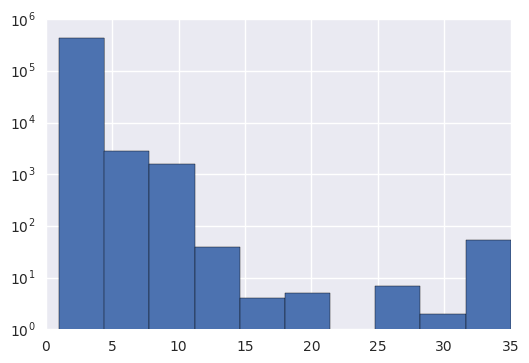

In [14]:
cookies['unique_useragents'].hist(log=True)

In [15]:
cookies_f = cookies[cookies['size'] < 25000]

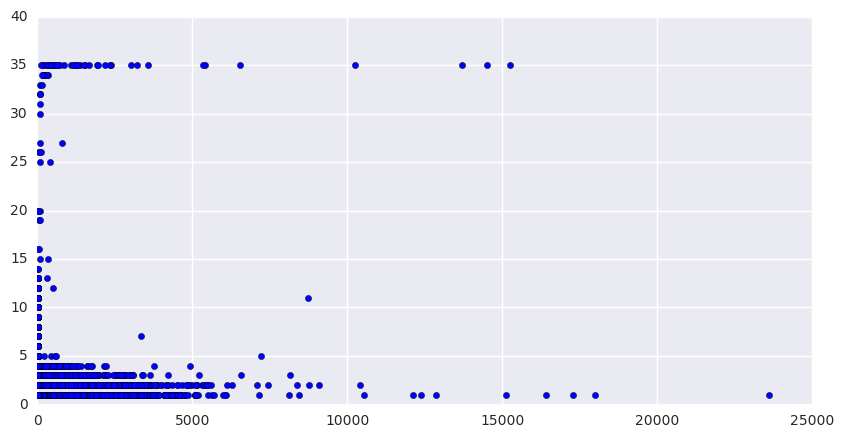

In [16]:
fig, ax = plt.subplots(figsize=[10, 5])
plt.axis([0, 25000, 0, 40])
plt.scatter(cookies_f['size'], cookies_f['unique_useragents'])

In [17]:
cookies.shape

(438657, 28)

In [18]:
cookies_1 = cookies[(cookies['size'] < 25000) & (cookies['agent_types'] == 'AVITO')]
cookies_2 = cookies[(cookies['size'] < 25000) & (cookies['agent_types'].isin(['MOZILLA', 'OPERA']))]
cookies_3 = cookies[(cookies['size'] < 25000) & ~(cookies['agent_types'].isin(['AVITO', 'MOZILLA', 'OPERA']))]

#### Исследуем cookies с приложений AVITO

In [19]:
cookies_1.shape

(56792, 28)

In [20]:
cookies_1[cookies_1['unique_useragents'] > 2].shape

(6124, 28)

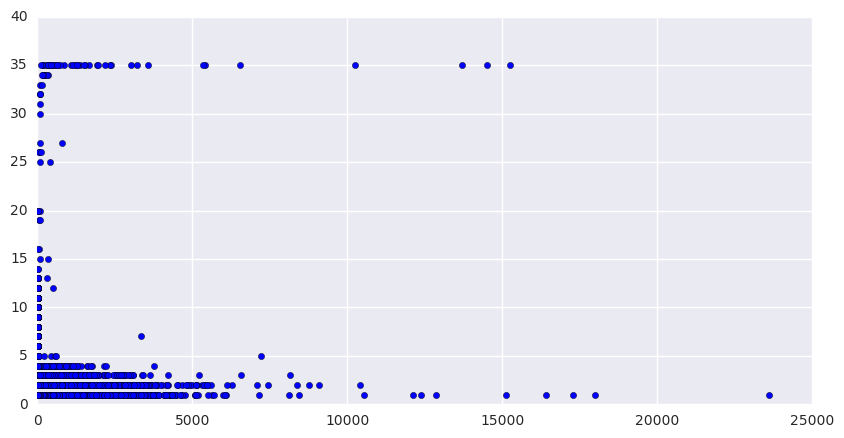

In [21]:
fig, ax = plt.subplots(figsize=[10, 5])
plt.axis([0, 25000, 0, 40])
plt.scatter(cookies_1['size'], cookies_1['unique_useragents'])

#### Исследуем cookies с браузеров MOZILLA и OPERA

Мало тех, кто делал много запросов. У них был только один агент

In [22]:
cookies_2[cookies_2['size'] > 50].shape

(113, 28)

Есть те, кто делал мало запросов, но у них менялся агент!

In [23]:
cookies_2[(cookies_2['size'] < 50) & (cookies_2['unique_useragents'] > 1)].shape

(1519, 28)

В основном это те, кто смотрел мало с одного агента

In [24]:
cookies_2[(cookies_2['size'] < 50) & (cookies_2['unique_useragents'] == 1)].shape

(359638, 28)

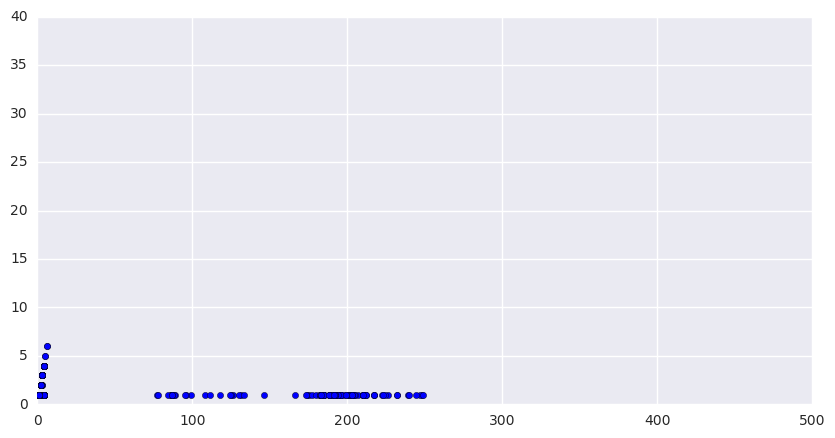

In [25]:
fig, ax = plt.subplots(figsize=[10, 5])
plt.axis([0, 500, 0, 40])
plt.scatter(cookies_2['size'], cookies_2['unique_useragents'])

#### Исследуем cookies с "плохими" агентами. Они включают в себя OTHER, HASH и смеси различных типов агентов

In [26]:
cookies_3.shape

(20592, 28)

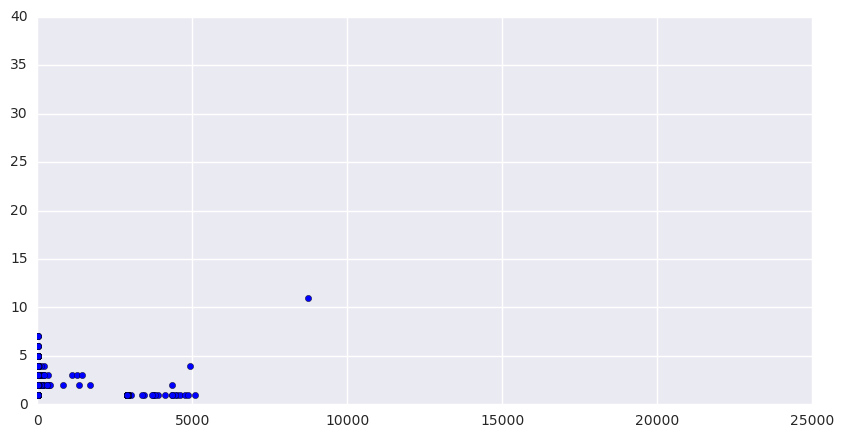

In [27]:
fig, ax = plt.subplots(figsize=[10, 5])
plt.axis([0, 25000, 0, 40])
plt.scatter(cookies_3['size'], cookies_3['unique_useragents'])

## Финальный сабмишн

In [28]:
strange_avito = cookies_1[((cookies_1['unique_events'] < 2) & (cookies_1['eventype'] == 'Items Search') | (cookies_1['unique_useragents'] > 2)) | ((cookies_1['unique_events'] == 2) & (cookies_1['unique_useragents'] == 2)) | (cookies_1['size'] > 4000)]

In [29]:
sample_sub.loc[:, 'IsHuman'] = 0
sample_sub.loc[cookies_1.index, 'IsHuman'] = 1
sample_sub.loc[strange_avito.index, 'IsHuman'] = 0
sample_sub.to_csv('../submissions/t2_0902_avito_with_corr_2.csv', index=False)

In [30]:
(sample_sub['IsHuman'] == 1).sum()

48531